<a href="https://colab.research.google.com/github/Lyra7417/Anomaly_Detection/blob/master/Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.utils.data as Data
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
(X_train_original,t_train_original),(X_test_original,t_test_original) = tf.keras.datasets.mnist.load_data()
X_train = X_train_original/255.
X_test = X_test_original/255.

X_normal = [X_train[i] for i in range(len(X_train)) if t_train_original[i]!=0]
y_normal = np.ones(len(X_normal))
X_anomaly = [X_train[i] for i in range(len(X_train)) if t_train_original[i]==0]

X_normal = torch.Tensor(X_normal)
X_anomaly = torch.Tensor(X_anomaly)
y_normal = torch.Tensor(y_normal)

train_data = Data.TensorDataset(X_normal,y_normal)

In [0]:
#定义超参数
EPOCH = 10
BATCH_SIZE = 100
LR = 0.005

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        #压缩
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.Tanh(),
            nn.Linear(500, 125),
            nn.Tanh(),
            nn.Linear(125, 40),
            nn.Tanh(),
            nn.Linear(40, 5),
        )
        #解压
        self.decoder = nn.Sequential(
            nn.Linear(5, 40),
            nn.Tanh(),
            nn.Linear(40, 125),
            nn.Tanh(),
            nn.Linear(125, 500),
            nn.Tanh(),
            nn.Linear(500, 28*28),
            nn.Sigmoid(),       #Sigmooid函数让输出值在(0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()

In [0]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

for epoch in range(EPOCH):
    for step, (x,y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   #batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   #batch y, shape (batch, 28*28)
 
        encoded, decoded = autoencoder(b_x)
 
        loss = loss_func(decoded, b_y)     #mean square error
        optimizer.zero_grad()           #clear gradients for this training step
        loss.backward()              #backpropagation, compute gradients
        optimizer.step()              #apply gradients

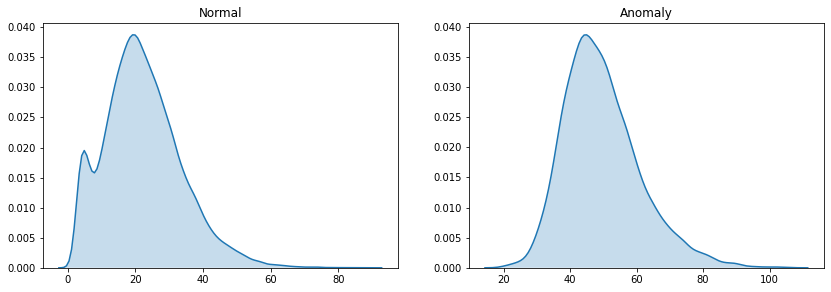

In [27]:
def Reconstruct_error(model, data):
    input_data = Variable(data.view(-1, 28*28).type(torch.FloatTensor))
    _, output_data = autoencoder(input_data)
    input_data, output_data = input_data.detach().numpy(), output_data.detach().numpy()
    #二值化
    
    MSE = np.sum((output_data-input_data)**2,axis = 1)
    return MSE

err_normal = Reconstruct_error(autoencoder, train_loader.dataset.tensors[0])
err_anomaly = Reconstruct_error(autoencoder, X_anomaly)

plt.figure(figsize = (14,4.5))
plt.subplot(121)
plt.title('Normal')
sns.kdeplot(err_normal,shade=True)
plt.subplot(122)
plt.title('Anomaly')
sns.kdeplot(err_anomaly,shade=True)

In [25]:
y_test = t_test_original==0

X_test = torch.tensor(X_test).float()
err = Reconstruct_error(autoencoder, X_test)
yhat = err>35

anom_test = yhat[y_test]
anomaly_accuracy = np.sum(anom_test)/len(anom_test)
nom_test = ~yhat[~(y_test)]
normal_accuracy = np.sum(nom_test)/len(nom_test)
print("Normal accuracy:",normal_accuracy)
print("Anomaly accuracy:",anomaly_accuracy)

Normal accuracy: 0.8666297117516629
Anomaly accuracy: 0.9418367346938775
